In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

#The binomial distribution determines the probability of observing a specified number of successful outcomes in a specified number of trials.

In [2]:
credit = pd.read_csv(r'D:\Microsoft Edx\Principles-of-Machine-Learning-Python-master\Module4\German_Credit_Preped.csv')
print(credit.shape)
credit.head()

(1000, 22)


,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1


The label has significant **class imbalance**. 

In [3]:
print(credit['credit_history'].value_counts())
credit_counts = credit[['credit_history', 'bad_credit']].groupby('bad_credit').count()
print(credit_counts)

current loans paid                         530
critical account - other non-bank loans    293
past payment delays                         88
all loans at bank paid                      49
no credit - paid                            40
Name: credit_history, dtype: int64
            credit_history
bad_credit                
0                      700
1                      300


In [4]:
labels = np.array(credit['bad_credit'])

In [5]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['credit_history', 'purpose', 'gender_status', 
                       'time_in_residence', 'property']

Features = encode_string(credit['checking_account_status'])
for col in categorical_columns:
    temp = encode_string(credit[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(1000, 31)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0.]]


In [6]:
Features = np.concatenate([Features, np.array(credit[['loan_duration_mo', 'loan_amount', 
                            'payment_pcnt_income', 'age_yrs']])], axis = 1)

#payment percent income means how much percent of income you can afford
print(Features.shape)
print(Features[:2, :])   

(1000, 35)
[[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 6.000e+00 1.169e+03 4.000e+00 6.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 4.800e+01 5.951e+03 2.000e+00 2.200e+01]]


In [7]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])
print(X_train[:2,31:])

[[3.900e+01 4.933e+03 2.000e+00 2.500e+01]
 [2.400e+01 7.721e+03 1.000e+00 3.000e+01]]


In [8]:
scaler = preprocessing.StandardScaler().fit(X_train[:,31:])
X_train[:,31:] = scaler.transform(X_train[:,31:])
X_test[:,31:] = scaler.transform(X_test[:,31:])
X_train[:2,:]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.53154035,  0.62707145, -0.86525095, -0.93382362],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.27037074,  1.65067659, -1.

The four numeric features are now scaled. 

## Building the logistic regression model


In [20]:
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.45, 1: 0.55})

In [21]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.37442751]
[[ 0.18551558  0.90228343 -0.086374   -1.00153612  0.49972928 -0.90793042
  -0.22193012  0.79100237 -0.16098222  0.06277323  0.57977273 -0.49044732
   0.17774209  0.22468284  0.12989851 -0.29217971 -0.30032274  0.15514287
  -0.24717362  0.0977708   0.20052882  0.07996986 -0.3783806  -0.32042135
   0.37374797 -0.17191534  0.11847761 -0.07000808  0.09861633 -0.32196667
   0.29324731  0.26895191  0.18615487  0.24406489 -0.1816684 ]]


In [22]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.81633129 0.18366871]
 [0.35813806 0.64186194]
 [0.92983552 0.07016448]
 [0.28576194 0.71423806]
 [0.52020312 0.47979688]
 [0.96646028 0.03353972]
 [0.9343145  0.0656855 ]
 [0.5711197  0.4288803 ]
 [0.85237475 0.14762525]
 [0.90357214 0.09642786]
 [0.53238746 0.46761254]
 [0.36408304 0.63591696]
 [0.47451694 0.52548306]
 [0.65714007 0.34285993]
 [0.3212414  0.6787586 ]]


In [23]:
def score_model(probs, threshold):
    
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

scores = score_model(probabilities, 0.5)

print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 0 0 0 0 0 0 0 1 1 0 1]
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]


In [24]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive       177                35
Actual negative        33                55

Accuracy  0.77
 
           Positive      Negative
Num case      212            88
Precision    0.84          0.61
Recall       0.83          0.62
F1           0.84          0.62


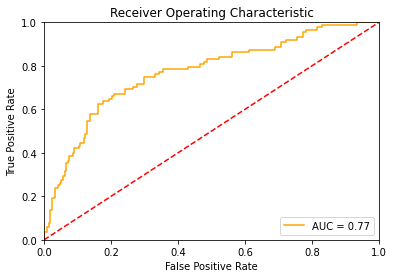

In [14]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)    

we can see the accuracy from this classifier is 0.77.

## Find a better threshold


In [25]:
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.45, 0.40, 0.35, 0.3, 0.25]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.45
                 Confusion matrix
                 Score positive    Score negative
Actual positive       165                47
Actual negative        30                58

Accuracy  0.74
 
           Positive      Negative
Num case      212            88
Precision    0.85          0.55
Recall       0.78          0.66
F1           0.81          0.60

For threshold = 0.4
                 Confusion matrix
                 Score positive    Score negative
Actual positive       154                58
Actual negative        26                62

Accuracy  0.72
 
           Positive      Negative
Num case      212            88
Precision    0.86          0.52
Recall       0.73          0.70
F1           0.79          0.60

For threshold = 0.35
                 Confusion matrix
                 Score positive    Score negative
Actual positive       143                69
Actual negative        22                66

Accuracy  0.70
 
           Positive      Negative
Num cas